## Additional Feature -- IoT Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/P1_Final/"
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as graphplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P1_Final
importing Jupyter notebook from plotlib_helper.ipynb
importing Jupyter notebook from datapreprocess_helper.ipynb


In [ ]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

path = "/content/drive/My Drive/P1_Final/"
    
filepath_train = os.path.join(path,"data/IoT_Botnet_Training.csv") 
filepath_test = os.path.join(path,"data/IoT_Botnet_Testing.csv") 

df_train= pd.read_csv(filepath_train, na_values=['NA','?','-'])
df_test= pd.read_csv(filepath_test, na_values=['NA','?','-'])
print(df_train.shape)
print(df_test.shape)



(2934817, 19)
(733705, 19)


In [ ]:
df_train[0:5]

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
df_train.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)


# drop id column
df_train.drop(columns=['pkSeqID'], axis= 1, inplace=True)
df_test.drop(columns=['pkSeqID'], axis= 1, inplace=True)
df_train[0:5]

,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
df_train.dtypes

proto                 object
saddr                 object
sport                 object
daddr                 object
dport                 object
seq                    int64
stddev               float64
N_IN_Conn_P_SrcIP      int64
min                  float64
state_number           int64
mean                 float64
N_IN_Conn_P_DstIP      int64
drate                float64
srate                float64
max                  float64
attack                 int64
category              object
subcategory           object
dtype: object

In [ ]:
category_col= ['proto','saddr','daddr', 'category', 'subcategory', 'state_number']
zscore_col = ['N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP', 'mean', 'drate', 'srate', 'max', 'min', 'stddev']
non_normalize = ['attack', 'sport', 'dport', 'seq']

for cat_col in category_col:

  train_labels = df_train[cat_col].unique();
  test_labels = df_test[cat_col].unique();
  intersection_set = set.intersection(set(train_labels), set(test_labels))
  commom_cat = list(intersection_set)

  indexNames_train = df_train[~(df_train[cat_col].isin(commom_cat))].index
  df_train.drop(indexNames_train , inplace=True)

  indexNames_test = df_test[~(df_test[cat_col].isin(commom_cat))].index
  df_test.drop(indexNames_test , inplace=True)


In [ ]:
for col in zscore_col:
  dataprep.encode_numeric_zscore(df_train, col)
  dataprep.encode_numeric_zscore(df_test, col)

for col in category_col:
  dataprep.encode_text_dummy(df_train, col)
  dataprep.encode_text_dummy(df_test, col)

print(df_train.shape, df_test.shape)

(2934710, 94) (733698, 94)


In [ ]:
df_train['sport'] = pd.to_numeric(df_train['sport'], errors='coerce')
df_train['dport'] = pd.to_numeric(df_train['dport'], errors='coerce')

df_test['sport'] = pd.to_numeric(df_test['sport'], errors='coerce')
df_test['dport'] = pd.to_numeric(df_train['dport'], errors='coerce')

In [ ]:
df_train.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)

In [ ]:
df_test.isnull().sum()

sport                0
dport                0
seq                  0
stddev               0
N_IN_Conn_P_SrcIP    0
                    ..
state_number-6       0
state_number-7       0
state_number-9       0
state_number-10      0
state_number-11      0
Length: 94, dtype: int64

In [ ]:
print(df_train['attack'].value_counts())
print(df_test['attack'].value_counts())

1    2927213
0        269
Name: attack, dtype: int64
1    729985
0       100
Name: attack, dtype: int64


In [ ]:
x_train, y_train = dataprep.to_xy(df_train, "attack")
x_test, y_test = dataprep.to_xy(df_test, "attack")

In [ ]:
filepath_savemodel = os.path.join(path,"dnn/proj1_IoT_neuralnet.hdf5")
# checkpoint to save the best weights 
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True) # save best model


for i in range(2):
    neuralnets_model = Sequential()
    neuralnets_model.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))
    neuralnets_model.add(Dense(10, activation='relu'))
    neuralnets_model.add(Dense(y_train.shape[1], activation='softmax'))
    neuralnets_model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=2, verbose=2, mode='auto')

    neuralnets_model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=100,batch_size=1000)


neuralnets_model.load_weights(filepath_savemodel) # load weights from best model


Epoch 1/100
2928/2928 - 8s - loss: 0.0170 - val_loss: 0.0116
Epoch 2/100
2928/2928 - 8s - loss: 0.0033 - val_loss: 0.0024
Epoch 3/100
2928/2928 - 7s - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
2928/2928 - 7s - loss: 9.0875e-04 - val_loss: 0.0012
Epoch 5/100
2928/2928 - 8s - loss: 8.3409e-04 - val_loss: 0.0011
Epoch 00005: early stopping
Epoch 1/100
2928/2928 - 7s - loss: 1.0311 - val_loss: 0.0070
Epoch 2/100
2928/2928 - 7s - loss: 0.0134 - val_loss: 0.2111
Epoch 3/100
2928/2928 - 7s - loss: 0.0048 - val_loss: 0.0035
Epoch 00003: early stopping


Performance Metrics - Neural Nets for IoT Dataset
---------------------------------------
Accuracy score: 0.9998712478683989
Precision score: 0.9998712644456466
Recall score: 0.9998712478683989
F1 score: 0.9998141638036828


[[     6     94]
 [     0 729985]]


Plotting confusion matrix


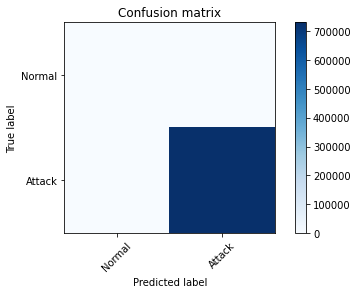



              precision    recall  f1-score   support

           0       1.00      0.06      0.11       100
           1       1.00      1.00      1.00    729985

    accuracy                           1.00    730085
   macro avg       1.00      0.53      0.56    730085
weighted avg       1.00      1.00      1.00    730085




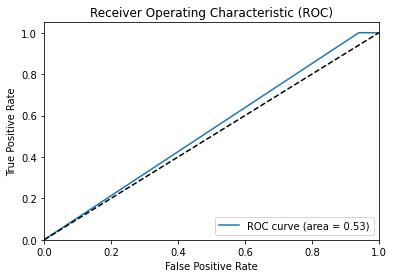

In [ ]:
pred = neuralnets_model.predict(x_test)
pred = np.argmax(pred,axis=1)
graphplot.performance_metrics(pred, y_test, ["Normal", "Attack"], "Performance Metrics - Neural Nets for IoT Dataset")